In [1]:
import numpy as np
from visualize import plot_ratemaps, average_weights_vs_phase_diff, plot_average_weights_vs_phase_diff
from matplotlib import pyplot as plt
import seaborn as sns
import os

# set working directory
os.chdir('./models/steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001/data')

# import data

In [2]:
# import data of band cell
score = np.load('band_score.npy')

ratemap = np.load('rate_map.npy')
activations = np.load('activations.npy')
activations_theta = np.load('activations_theta.npy')

theta = np.load('orientation.npy') # orientation θ
L = np.load('L.npy') #  spacing λ

phase = np.load('phase.npy') # phase
prefer_dir = np.load('prefer_dir.npy')
dir_scores = np.load('direction_scores.npy')
A_params = np.load('A_params.npy')
sigma_params = np.load('sigma_params.npy')
mu_params = np.load('mu_params.npy')

# recurrent weight
J = np.load('J_matrix.npy').T

# band score

### Figure S2a: Band score distribution.

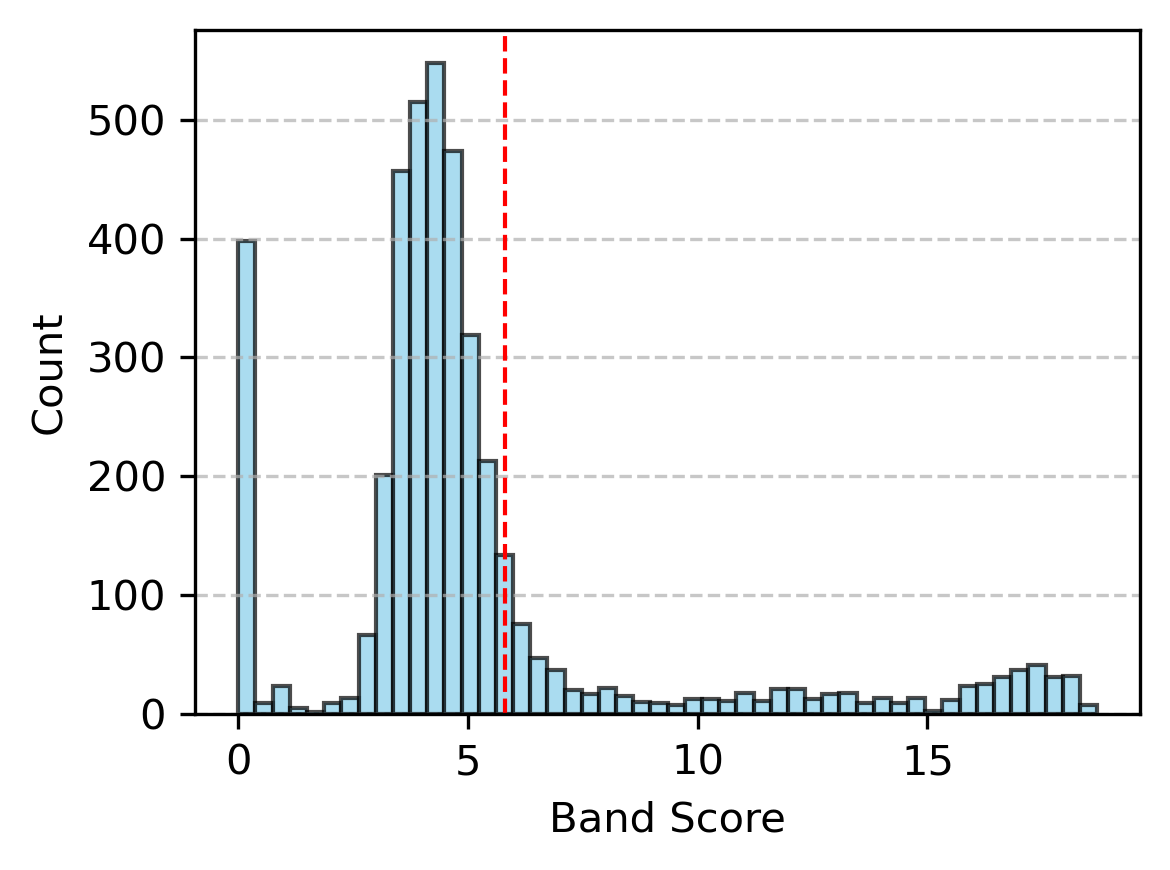

In [3]:
plt.figure(figsize=(4, 3), dpi=300)  # Set figure size
plt.hist(score, bins=50, color='skyblue', edgecolor='black', alpha=0.7)  # Set color, edge, and transparency
plt.xlabel('Band Score', fontsize=10)  # Set x-axis label
plt.ylabel('Count', fontsize=10)  # Set y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.axvline(x=5.8, color='red', linestyle='--', linewidth=1)  # Add vertical dashed line at x=5.8 (threshold)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [4]:
# Identify band cells
score_thres = 5.8 # threshold for band cells
index = np.argsort(-score)
index_band = index[np.where(score[index] > score_thres)[0]]
print('Band cell number:', index_band.shape[0])

Band cell number: 764


### Figure S2b: The top 128 band cells with the highest scores.

In [5]:
# flip the activations to match the imshow orientation
activations_swapped = np.swapaxes(activations, 1, 2)
activations_flipped = np.flip(activations_swapped, axis=(1))

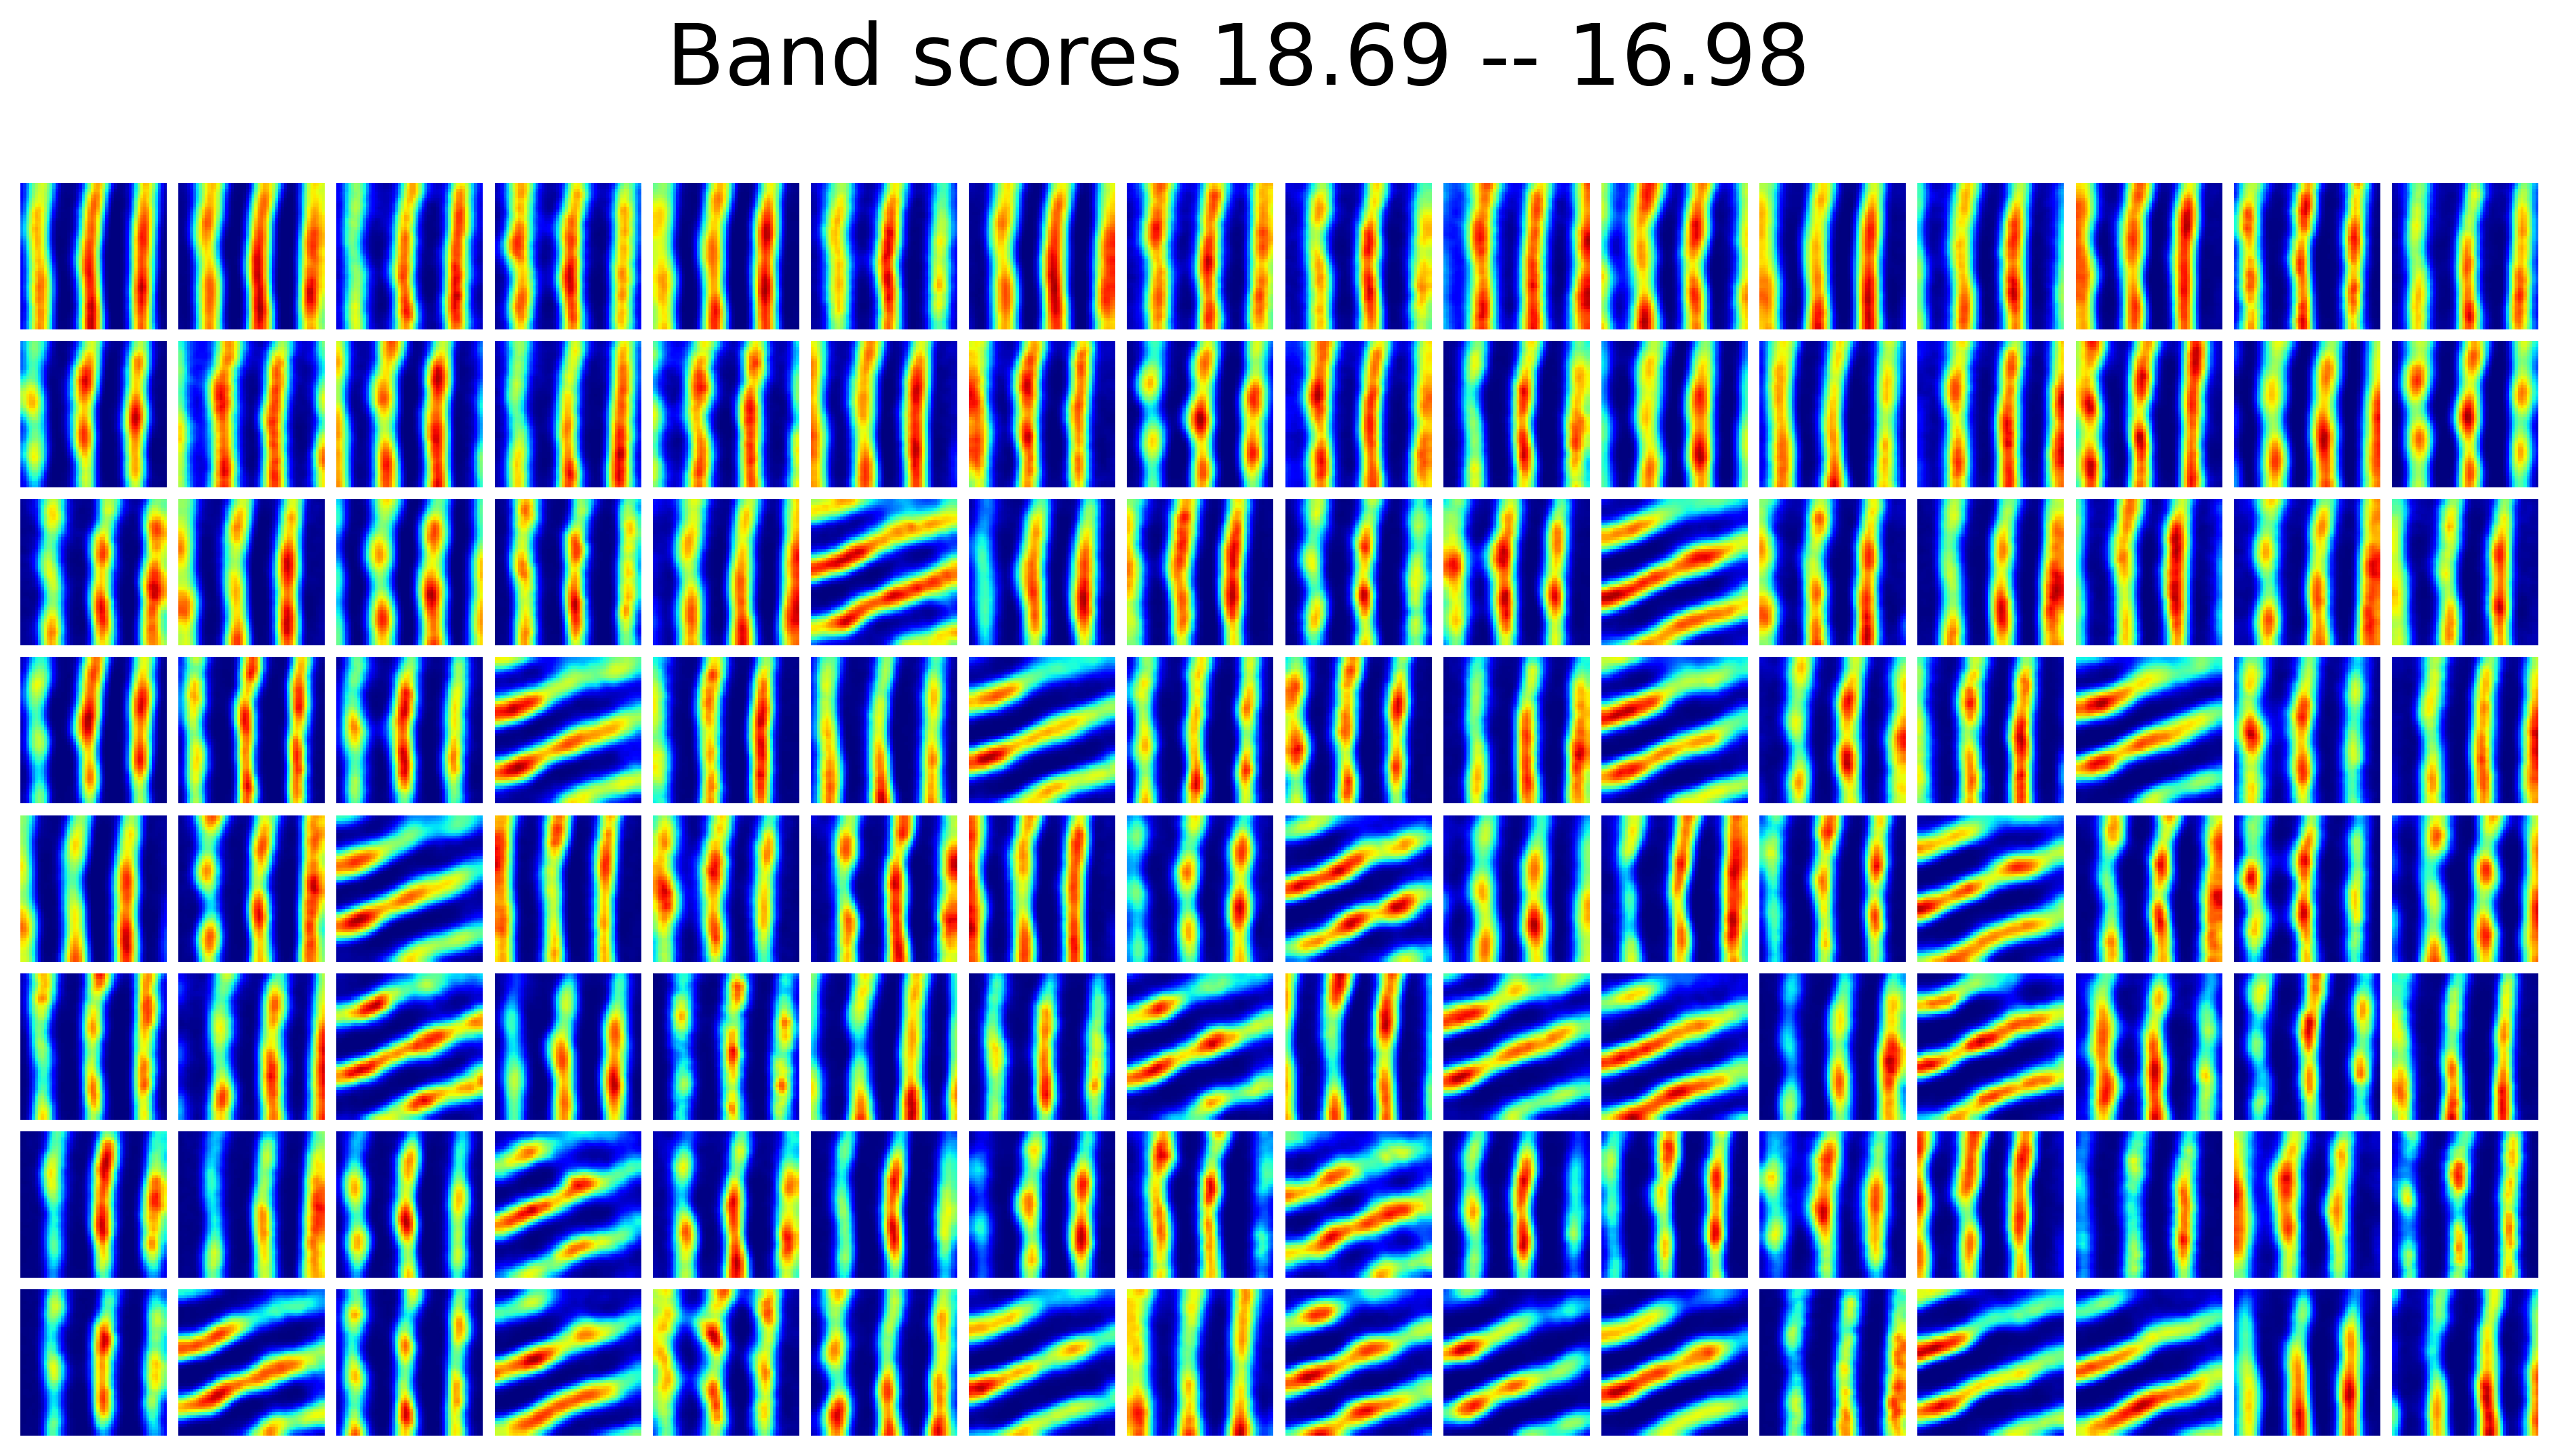

In [6]:
# Plot high band score cells
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2), dpi=300)
rm_fig = plot_ratemaps(activations_flipped[index_band], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Band scores '+str(np.round(score[index_band[0]], 2))
             +' -- '+ str(np.round(score[index_band[n_plot]], 2)),
            fontsize=30)
plt.axis('off');

# direction

In [7]:
# Identify high band score cells
score_thres = 5.8
high_band_idxs = np.where(score > score_thres)[0]
print(high_band_idxs.shape)

(764,)


### Figure 4c:  An example band cell with direction-tuning at π.

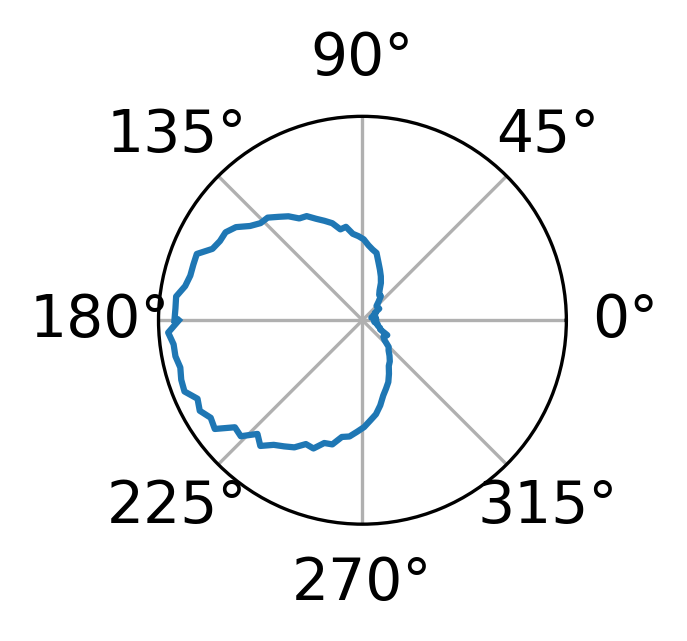

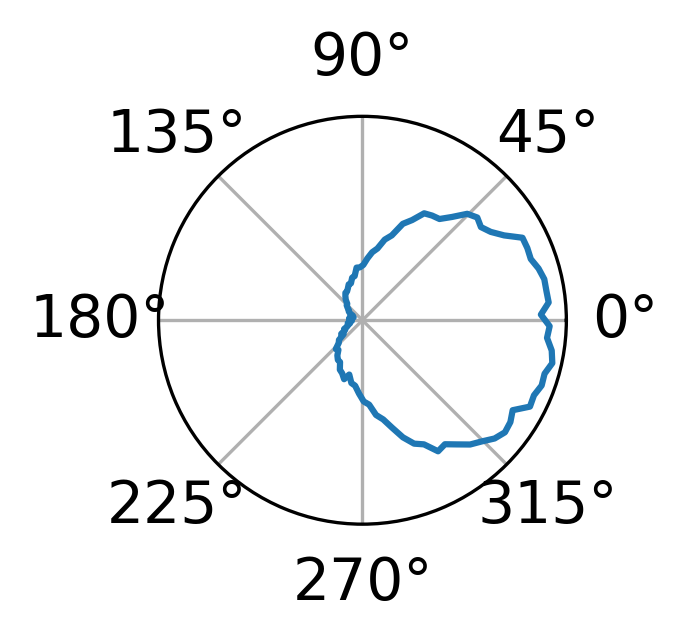

In [18]:
# Visualize the activity of the 141st cell in polar coordinates
fig_141, ax_141 = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(2.5, 2.5), dpi=300)
theta_141 = np.linspace(-np.pi, np.pi, len(activations_theta[141]))
ax_141.plot(theta_141, activations_theta[141])
ax_141.set_yticks([])
plt.tight_layout()
# fig_141.savefig('cell_141_activity.pdf')  # Save as PDF
plt.show()


# Visualize the activity of the 149th cell in polar coordinates
fig_149, ax_149 = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(2.5, 2.5), dpi=300)
theta_149 = np.linspace(-np.pi, np.pi, len(activations_theta[149]))
ax_149.plot(theta_149, activations_theta[149])
ax_149.set_yticks([])
plt.tight_layout()
# fig_149.savefig('cell_149_activity.pdf')  # Save as PDF
plt.show()

### Figure 4d: Distribution of directional scores (a measurement of the direction-tuning level) of band cells in an example cluster.

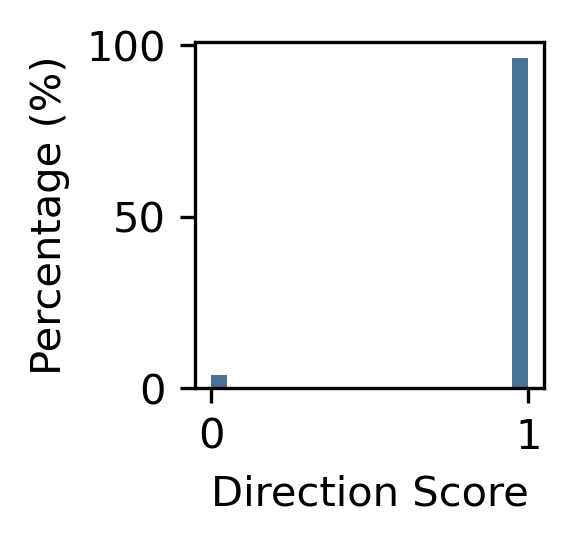

In [9]:
# Plot the distribution of direction scores of high band score cells
filtered_dir_scores = dir_scores[high_band_idxs]

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(1.5, 1.5), dpi=300)
plt.hist(filtered_dir_scores, bins=20, color='#4A7298', weights=np.ones_like(filtered_dir_scores) / len(filtered_dir_scores)) # 
plt.xlabel('Direction Score')
plt.ylabel('Percentage (%)')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
plt.show()

# spacing & orientation

### Figure 4b: Band cells in the trained RNN are grouped into four clusters according to their spacing λ and orientation θ. 

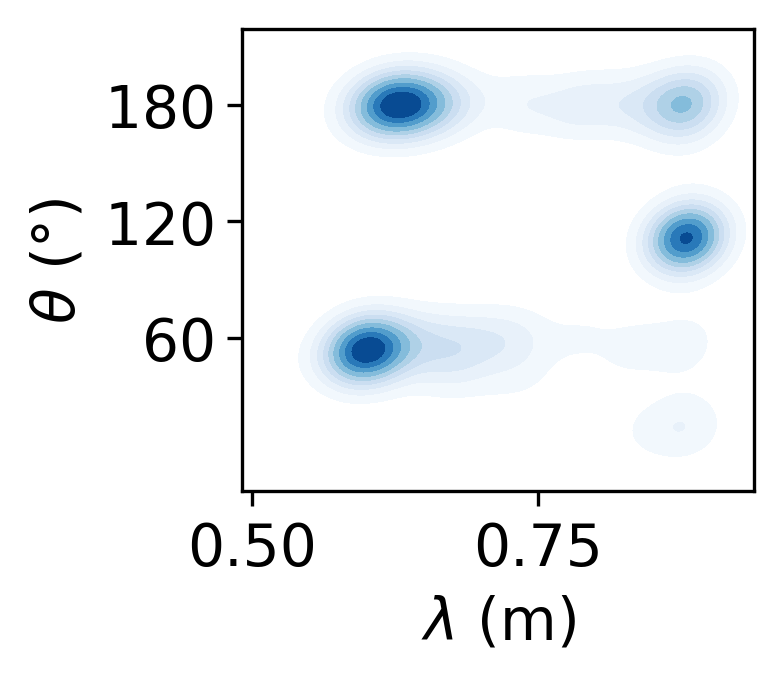

In [10]:
# Plot the distribution of high band score cells in (spacing, orientation) space
plt.figure(figsize=(2.2, 2), dpi=300)
plt.rcParams.update({'font.size': 14})
sns.kdeplot(x = L[index_band], 
            y = theta[index_band],  # Keep theta in degrees
            cmap = "Blues", fill = True, bw_adjust = 0.5)
plt.xlabel(r'$\lambda$ (m)')
plt.ylabel(r'$\theta$ (°)')
plt.yticks([60, 120, 180], [r'$60$', r'$120$', r'$180$'])
plt.show()

# Extract modules based on spacing & orientation

In [11]:
# high band score cells
score_thres = 5.8
high_band_idxs = np.where(score > score_thres)[0]

# threshold for spacing and orientation to extract modules
L_1_theta_1 = np.where((L < 0.625) & (theta < 80))[0]
L_1_theta_2 = np.where((L < 0.7) & (theta > 120))[0]
L_2_theta_3 = np.where((L > 0.85) & (theta > 80) & (theta < 130))[0]
L_2_theta_2 = np.where((L > 0.875) & (theta > 130))[0]

# take the intersection with high_band_idxs
L_1_theta_2 = np.intersect1d(L_1_theta_2, high_band_idxs)
L_1_theta_1 = np.intersect1d(L_1_theta_1, high_band_idxs)
L_2_theta_3 = np.intersect1d(L_2_theta_3, high_band_idxs)
L_2_theta_2 = np.intersect1d(L_2_theta_2, high_band_idxs)

In [12]:
L_1_theta_1.shape, L_1_theta_2.shape, L_2_theta_3.shape, L_2_theta_2.shape

((168,), (215,), (135,), (57,))

#### Figure 4e: Histograms of preferred directions of band cells in two example clusters, which have a bimodal shape peaked at either the cluster orientation θ or its opposite direction θ + π.

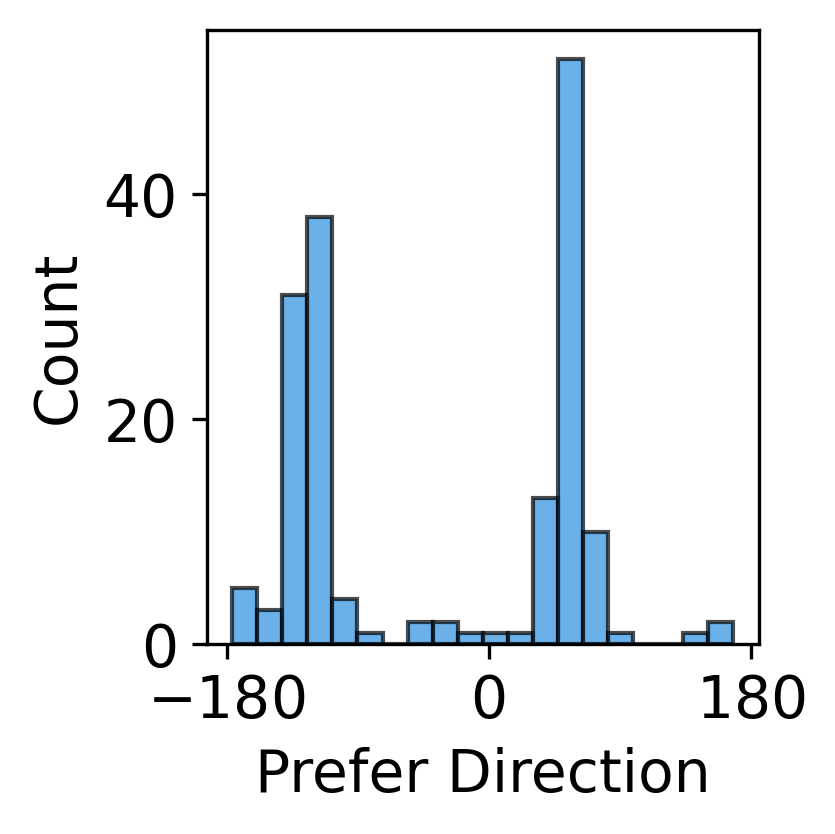

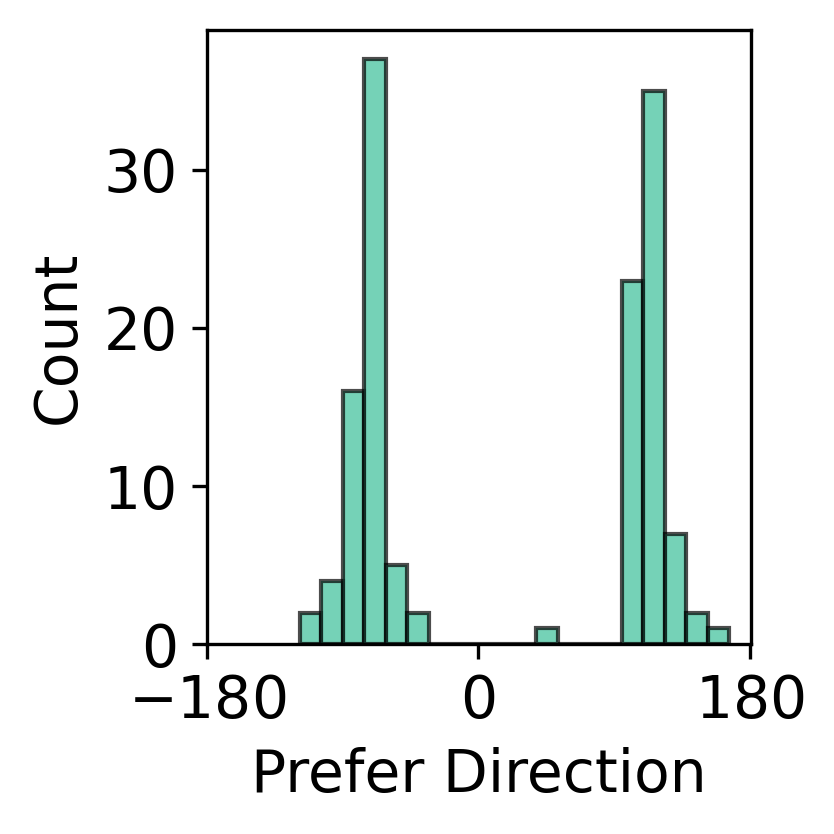

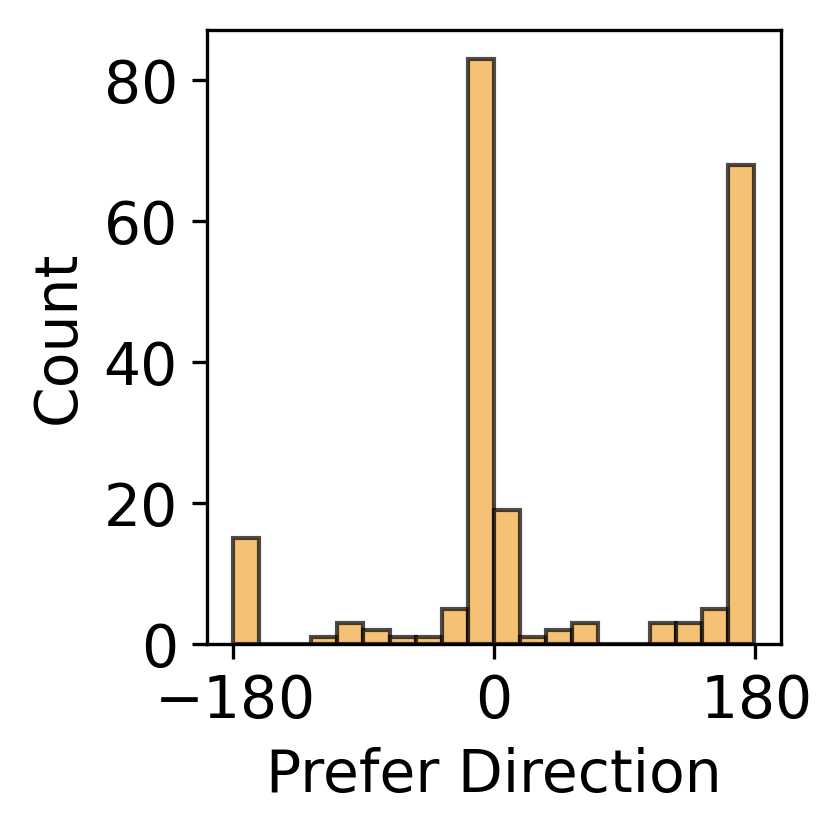

In [13]:
# Convert prefer_dir from radians to degrees
prefer_dir_low_theta_low = np.degrees(prefer_dir[L_1_theta_2])
prefer_dir_low_theta_high = np.degrees(prefer_dir[L_1_theta_1])
prefer_dir_high_theta_mid = np.degrees(prefer_dir[L_2_theta_3])
prefer_dir_high_theta_low = np.degrees(prefer_dir[L_2_theta_2])

plt.rcParams.update({'font.size': 14})

# Plot the prefer_dir distribution of L_1_theta_1
plt.figure(figsize=(3, 3), dpi=300)
plt.hist(prefer_dir_low_theta_high, bins=20, color='#2C91E0', alpha=0.7, edgecolor='black')
plt.xlabel('Prefer Direction')
plt.ylabel('Count')
plt.xticks([-180, 0, 180], [r'$-180$', '0',  r'$180$'])  # Set x-axis to degrees
plt.tight_layout()
plt.show()

# Plot the prefer_dir distribution for L_2_theta_3
plt.figure(figsize=(3, 3), dpi=300)
plt.hist(prefer_dir_high_theta_mid, bins=20, color='#3ABF99', alpha=0.7, edgecolor='black')
plt.xlabel('Prefer Direction')
plt.ylabel('Count')
plt.xticks([-180, 0, 180], [r'$-180$', '0',  r'$180$'])  # Set x-axis to degrees
plt.tight_layout()
plt.show()

# Plot the prefer_dir distribution of L_1_theta_2
plt.figure(figsize=(3, 3), dpi=300)
plt.hist(prefer_dir_low_theta_low, bins=20, color='#F0A73A', alpha=0.7, edgecolor='black')
plt.xlabel('Prefer Direction')
plt.ylabel('Count')
plt.xticks([-180, 0, 180], [r'$-180$', '0',  r'$180$'])  # Set x-axis to degrees
plt.tight_layout()
plt.show()


### Figure S3a: The averaged connection profile of band cells as a function of their phase difference. In figures a and c, colors indicate distinct band cell clusters, and each cluster has the same spacing and orientation.

In [ ]:
# Connection Weight Matrix for Four Networks
L_1_theta_2_idxs = L_1_theta_2[np.argsort(phase[L_1_theta_2])]
L_1_theta_1_idxs = L_1_theta_1[np.argsort(phase[L_1_theta_1])]
L_2_theta_3_idxs = L_2_theta_3[np.argsort(phase[L_2_theta_3])]

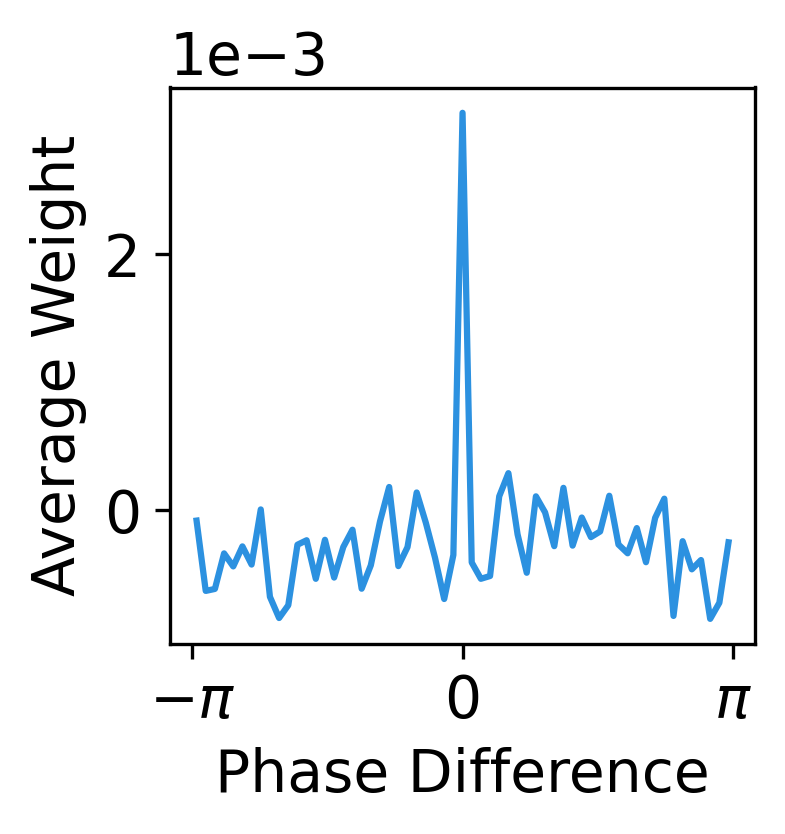

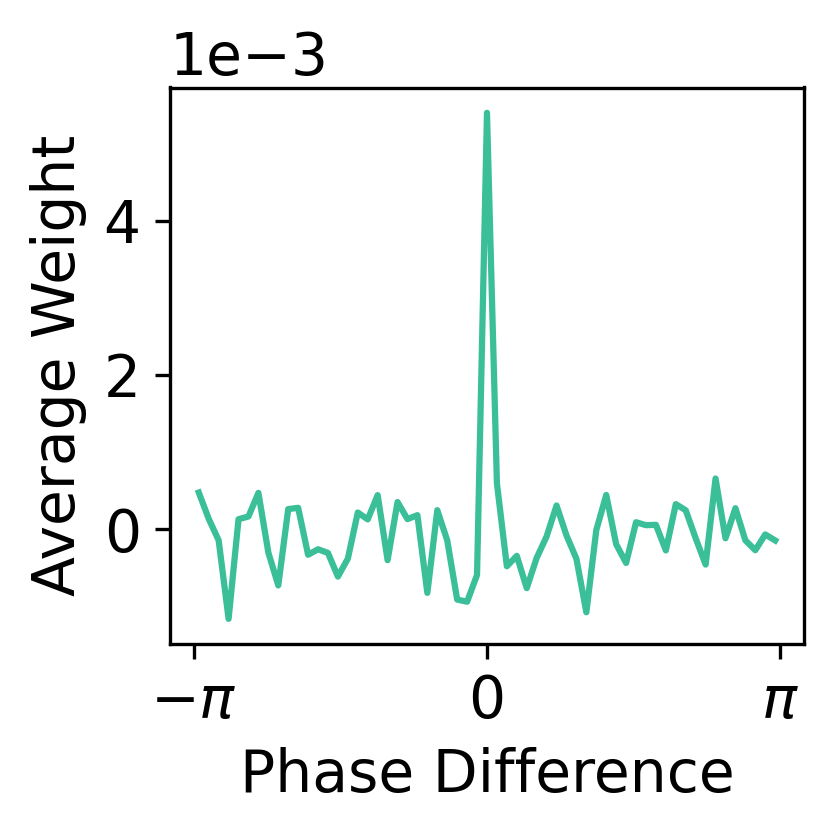

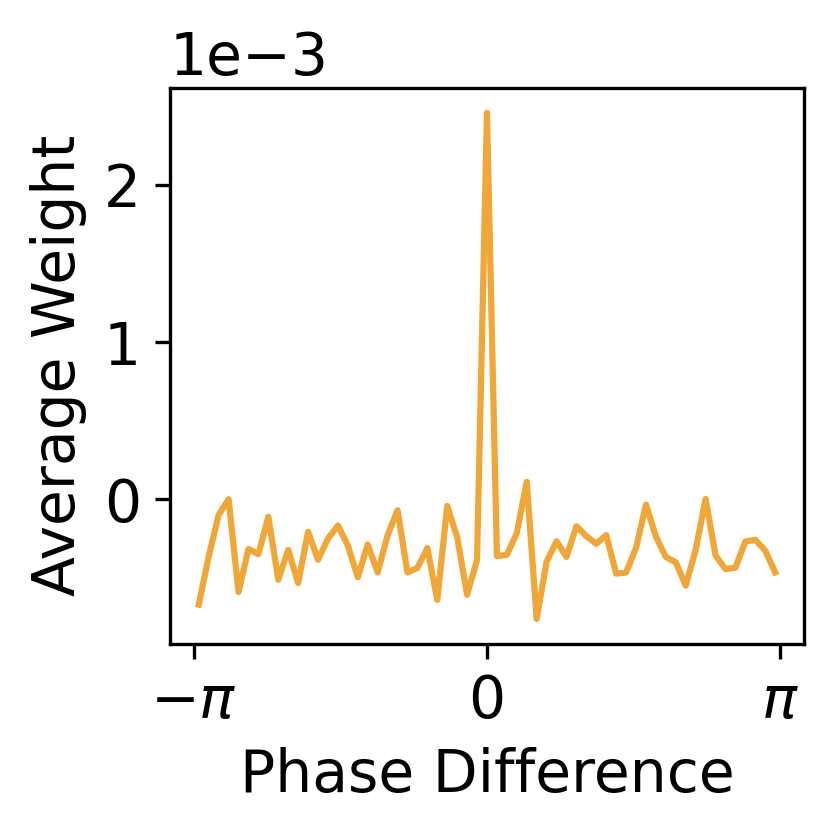

In [16]:
# Plot the average weight of L_1_theta_1_idxs
plt.figure(figsize=(3, 3), dpi=300)
bin_centers, avg_weights = average_weights_vs_phase_diff(phase, J, L_1_theta_1_idxs)
plt.plot(bin_centers, avg_weights, color='#2C91E0')
plt.xlabel('Phase Difference')
plt.ylabel('Average Weight')
plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])  # Set x-axis ticks
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Set y-axis to scientific notation
plt.tight_layout()
plt.show()

# Plot the average weight of L_2_theta_3_idxs
plt.figure(figsize=(3, 3), dpi=300)
bin_centers, avg_weights = average_weights_vs_phase_diff(phase, J, L_2_theta_3_idxs)
plt.plot(bin_centers, avg_weights, color='#3ABF99')
plt.xlabel('Phase Difference')
plt.ylabel('Average Weight')
plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])  # Set x-axis ticks
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Set y-axis to scientific notation
plt.tight_layout()
plt.show()

# Plot the average weight of L_1_theta_2_idxs
plt.figure(figsize=(3, 3), dpi=300)
bin_centers, avg_weights = average_weights_vs_phase_diff(phase, J, L_1_theta_2_idxs)
plt.plot(bin_centers, avg_weights, color='#F0A73A')
plt.xlabel('Phase Difference')
plt.ylabel('Average Weight')
plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])  # Set x-axis ticks
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Set y-axis to scientific notation
plt.tight_layout()
plt.show()


### Figure 4g: The averaged connection profile of band cells as a function of their phase difference.

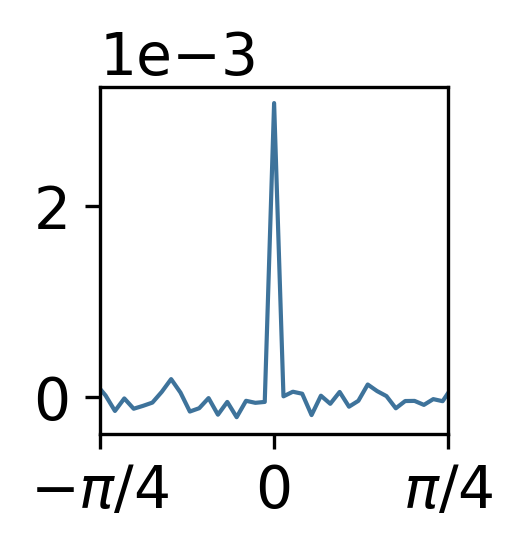

In [ ]:
# Plot the average weight of 3 modules
idxs = np.concatenate((L_1_theta_1, L_1_theta_2, L_2_theta_3))

fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
plot_average_weights_vs_phase_diff(phase, J, ax, idxs, '', 150)
ax.lines[-1].set_color((62/255, 115/255, 155/255))  # Set color
ax.lines[-1].set_linewidth(1)  # Set line width

# Set y-axis to scientific notation and specify ticks
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax.set_xticks([-np.pi/4, 0, np.pi/4])
ax.set_xticklabels([r'$-\pi/4$', '0', r'$\pi/4$'])
ax.set_xlim([-np.pi/4, np.pi/4])

plt.show()